In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gpflow
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from xgboost import XGBRegressor
import joblib

2024-06-15 20:34:40.593526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 20:34:40.847258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/apps/22.04/openmpi/4.1.5/lib:/share/apps/22.04/slurm/23.02.7/lib
2024-06-15 20:34:40.847315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-15 20:34:40.898835: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has al

In [2]:
pfts = ["Tropical", "Temperate_Broadleaf","Temperate_Deciduous"
        ,"Temperate_Coniferous","Boreal"]

var_list = ['GPP', 'NPP', 'VEGC', 'SOILORGC']


In [100]:
pft = pfts[4]
all_model_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/merged_outliers_removed/'+pft+'_cru_hist_canesm5_ssp245.csv')


In [101]:
test_output = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/model_output/Y_test_'+pft+'.csv')




In [102]:
test_output['GPP_res'] = test_output['GPP'] - test_output['GPP_pred']
test_output['NPP_res'] = test_output['NPP'] - test_output['NPP_pred']
test_output['VEGC_res'] = test_output['VEGC'] - test_output['VEGC_pred']
test_output['SOILORGC_res'] = test_output['SOILORGC'] - test_output['SOILORGC_pred']

In [103]:
all_model_data['year'].max()

2021

In [104]:
pred_vars = ['ordinal_stand_age'
                         ,'nirr_avg', 'nirr_min', 'nirr_max', 'prec_avg',
       'prec_min', 'prec_max', 'tair_avg', 'tair_min', 'tair_max',
       'trange_avg', 'trange_min', 'trange_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
# Get the indices and split them
indices = np.arange(len(all_model_data))
indices
train_indices, test_indices = train_test_split(indices, test_size=0.3, random_state=42)

# # Split the data using train_indices and test_indices
# X_test = all_model_data.loc[test_indices,pred_vars]
Y_test = all_model_data.loc[test_indices, ['stand_age_interval_min','GPP', 'NPP', 'VEGC', 'SOILORGC']]

# train_all_model_data = all_model_data.loc[train_indices]


In [105]:
Y_test = Y_test.reset_index()
Y_test

,index,stand_age_interval_min,GPP,NPP,VEGC,SOILORGC
0,4932684,10,64.33,28.88,1606.35,6907.48
1,4732016,30,0.41,0.16,2.48,5108.84
2,5560112,75,81.46,29.73,6327.08,10258.80
3,1733139,65,41.29,14.67,2883.32,6435.07
4,7079055,20,43.63,10.49,2036.55,8803.51
...,...,...,...,...,...,...
2715254,3123039,5,40.42,22.27,482.89,7723.29
2715255,6199914,80,72.24,28.45,6291.73,9332.24
2715256,5475270,25,74.29,26.21,3202.91,8834.80
2715257,7946286,0,2.78,1.39,23.78,6024.69


In [106]:
test_output = pd.concat([Y_test['stand_age_interval_min'], test_output], axis=1)
test_output

,stand_age_interval_min,GPP,NPP,VEGC,SOILORGC,GPP_pred,NPP_pred,VEGC_pred,SOILORGC_pred,GPP_res,NPP_res,VEGC_res,SOILORGC_res
0,10,64.33,28.88,1606.35,6907.48,29.480812,12.729580,592.613950,3836.9390,34.849188,16.150420,1013.736050,3070.5410
1,30,0.41,0.16,2.48,5108.84,21.200603,8.952106,1208.344400,6251.8690,-20.790603,-8.792105,-1205.864400,-1143.0290
2,75,81.46,29.73,6327.08,10258.80,76.255940,26.661161,5952.157700,10022.4000,5.204060,3.068839,374.922300,236.4000
3,65,41.29,14.67,2883.32,6435.07,48.999947,18.130268,3344.656000,8042.7817,-7.709947,-3.460268,-461.336000,-1607.7117
4,20,43.63,10.49,2036.55,8803.51,54.324680,19.130960,1981.032100,9016.1000,-10.694680,-8.640960,55.517900,-212.5900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715254,5,40.42,22.27,482.89,7723.29,49.067090,27.477268,522.259160,8854.0340,-8.647090,-5.207268,-39.369160,-1130.7440
2715255,80,72.24,28.45,6291.73,9332.24,70.594440,27.216745,6162.621000,9533.8480,1.645560,1.233255,129.109000,-201.6080
2715256,25,74.29,26.21,3202.91,8834.80,69.749275,25.254740,2844.546900,8518.2170,4.540725,0.955260,358.363100,316.5830
2715257,0,2.78,1.39,23.78,6024.69,2.069186,0.531664,3.750822,8904.5740,0.710814,0.858336,20.029178,-2879.8840


In [75]:
# plot_kde_with_means(test_output, "GPP", "GPP_pred", "GPP","Emulated GPP")

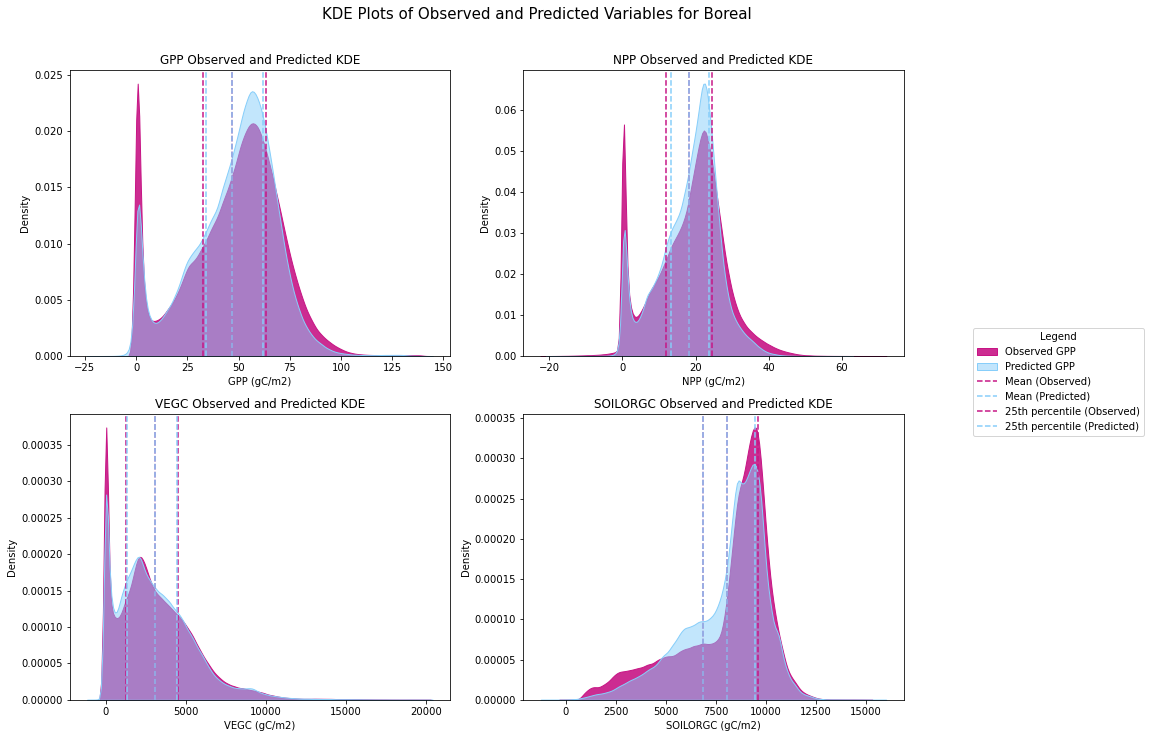

In [107]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
# Initialize lists for legend handlers and labels
all_handles = []
all_labels = []

# Loop through the vars_list and corresponding Axes
for ax, var in zip(axes, vars_list):
    var_pred = f'{var}_pred'
    var_label = f'Observed {var}'
    var_pred_label = f'Predicted {var}'
    
    # Calculate means and quantiles
    mean_var = test_output[var].mean()
    mean_var_pred = test_output[var_pred].mean()
    quantile25_var = test_output[var].quantile(0.25)
    quantile25_var_pred = test_output[var_pred].quantile(0.25)
    quantile75_var = test_output[var].quantile(0.75)
    quantile75_var_pred = test_output[var_pred].quantile(0.75)
    
    # Create KDE plots
    sns.kdeplot(test_output[var], ax=ax, fill=True, color="mediumvioletred", alpha=0.9, label=var_label)
    sns.kdeplot(test_output[var_pred], ax=ax, fill=True, color="lightskyblue", alpha=0.5, label=var_pred_label)
    
    # Add vertical lines for means and quantiles
    handles_var = [
        ax.axvline(x=mean_var, linestyle='--', color="mediumvioletred", label='Mean (Observed)'),
        ax.axvline(x=mean_var_pred, linestyle='--', color="lightskyblue", label='Mean (Predicted)'),
        ax.axvline(x=quantile25_var, linestyle='--', color="mediumvioletred", label='25th percentile (Observed)'),
        ax.axvline(x=quantile25_var_pred, linestyle='--', color="lightskyblue", label='25th percentile (Predicted)'),
        ax.axvline(x=quantile75_var, linestyle='--', color="mediumvioletred", label='75th percentile (Observed)'),
        ax.axvline(x=quantile75_var_pred, linestyle='--', color="lightskyblue", label='75th percentile (Predicted)')
    ]

    # Add handles for KDE plots
    sns_handles, _ = ax.get_legend_handles_labels()
    all_handles.extend(sns_handles)
    
    # Extract legend labels from the first plot
    if ax == axes[0]:
        all_handles.extend(handles_var)
        _, all_labels = ax.get_legend_handles_labels()
    
    ax.set_title(f'{var} Observed and Predicted KDE')
    ax.set_xlabel(f'{var} (gC/m2)')
    ax.set_ylabel('Density')

# Add a single legend for all subplots to the right of the grid
fig.legend(all_handles[:2] + handles_var[:2*3], all_labels[:2] + all_labels[2:2*3], loc='center left', bbox_to_anchor=(.9, 0.5), title="Legend")

plt.tight_layout(rect=[0, 0, 0.85, 0.97])  # Adjust layout so the legend fits
plt.suptitle(f"KDE Plots of Observed and Predicted Variables for {pft}", y=1.02, fontsize=15)
plt.show()



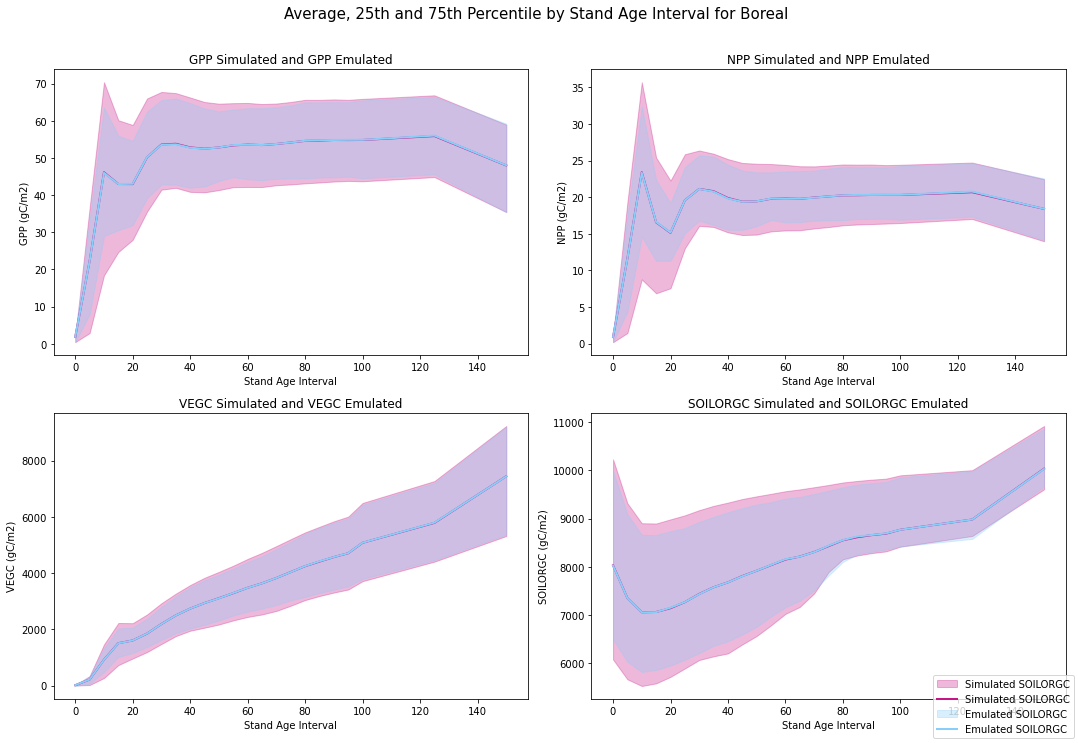

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
vars_list = ['GPP','NPP','VEGC','SOILORGC']

for ax, var in zip(axes, vars_list):
    # Perform aggregation for each variable
    result = test_output.groupby('stand_age_interval_min').apply(summary_functions, var_name=var).reset_index()

    # Plot data for each variable
    sim_label = f'Simulated {var}'
    emu_label = f'Emulated {var}'

    ax.fill_between(result['stand_age_interval_min'], result[f'{var}_q25'], result[f'{var}_q75'], alpha=0.3, color='mediumvioletred', label=sim_label)
    ax.plot(result['stand_age_interval_min'], result[f'{var}_mean'], color='mediumvioletred', linewidth=2, label=sim_label)

    ax.fill_between(result['stand_age_interval_min'], result[f'{var}_pred_q25'], result[f'{var}_pred_q75'], alpha=0.3, color='lightskyblue', label=emu_label)
    ax.plot(result['stand_age_interval_min'], result[f'{var}_pred_mean'], color='lightskyblue', linewidth=2, label=emu_label)

    ax.set_title(f'{var} Simulated and {var} Emulated')
    ax.set_xlabel("Stand Age Interval")
    ax.set_ylabel(f'{var} (gC/m2)')

# Add a single legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout so the legend fits
plt.suptitle(f"Average, 25th and 75th Percentile by Stand Age Interval for {pft}", y=1.02, fontsize=15)    
plt.show()


In [33]:
def plot_kde_with_means(data, var1, var2, var1_label, var2_label):
    # Calculate the means and quantiles
    mean_var1 = data[var1].mean()
    mean_var2 = data[var2].mean()
    quantile25_var1 = data[var1].quantile(0.25)
    quantile25_var2 = data[var2].quantile(0.25)
    quantile75_var1 = data[var1].quantile(0.75)
    quantile75_var2 = data[var2].quantile(0.75)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data[var1], fill=True, color="mediumvioletred", alpha=0.9, label=var1_label)
    sns.kdeplot(data[var2], fill=True, color="lightskyblue", alpha=0.5, label=var2_label)
    
    # Add vertical lines for means and quantiles
    plt.axvline(x=mean_var1, linestyle='--', color="mediumvioletred", label=f'{var1_label} Mean')
    plt.axvline(x=mean_var2, linestyle='--', color="lightskyblue", label=f'{var2_label} Mean')
    plt.axvline(x=quantile25_var1, linestyle='--', color="mediumvioletred", label=f'{var1_label} 25th percentile')
    plt.axvline(x=quantile25_var2, linestyle='--', color="lightskyblue", label=f'{var2_label} 25th percentile')
    plt.axvline(x=quantile75_var1, linestyle='--', color="mediumvioletred", label=f'{var1_label} 75th percentile')
    plt.axvline(x=quantile75_var2, linestyle='--', color="lightskyblue", label=f'{var2_label} 75th percentile')
    
    plt.title(f'KDE of {var1_label} for {pft}')
    plt.legend()
    plt.show()

In [44]:
var = 'GPP'
result = test_output.groupby('stand_age_interval_min').apply(summary_functions, var_name=var).reset_index()
result

,stand_age_interval_min,GPP_mean,GPP_q25,GPP_q75,GPP_pred_mean,GPP_pred_q25,GPP_pred_q75
0,0,63.513012,7.8400,103.3100,63.426338,22.863383,95.524693
1,5,140.325432,88.8200,192.0600,140.326406,92.345682,187.961585
2,10,150.922342,118.2700,192.3800,150.674052,118.679097,189.661482
3,15,149.959839,118.9400,189.8000,150.198400,123.418205,187.203442
4,20,158.522282,121.0700,202.8700,158.603346,132.831345,196.326530
5,25,166.857715,119.2400,221.5500,166.682533,137.671250,207.542880
6,30,152.136851,118.7500,192.3150,152.200197,133.390915,183.412285
7,35,148.566958,125.4800,179.1100,148.713132,133.909965,172.781120
8,40,147.149544,127.8225,174.8400,147.591703,133.003060,171.414283
9,45,147.333045,129.2200,174.6000,147.739298,133.152087,171.965060


In [51]:
def summary_functions(group, var_name):
    return pd.Series({
        f'{var_name}_mean': group[var_name].mean(),
        f'{var_name}_q25': group[var_name].quantile(0.25),
        f'{var_name}_q75': group[var_name].quantile(0.75),
        f'{var_name}_pred_mean': group[f'{var_name}_pred'].mean(),
        f'{var_name}_pred_q25': group[f'{var_name}_pred'].quantile(0.25),
        f'{var_name}_pred_q75': group[f'{var_name}_pred'].quantile(0.75)
    })

def plot_stand_age_range(data, var):
    # Perform aggregation
    result = data.groupby('stand_age_interval_min').apply(summary_functions, var_name=var).reset_index()
    
    # Check the structure of result
    print(result.head())  # Debugging line
    
    # Plot
    plt.figure(figsize=(10, 6))
    
    sim_label = f'Simulated {var}'
    emu_label = f'Emulated {var}'
    
    # Simulated variable ribbon and line
    plt.fill_between(result['stand_age_interval_min'], result[f'{var}_q25'], result[f'{var}_q75'], alpha=0.3, color='mediumvioletred', label=sim_label)
    plt.plot(result['stand_age_interval_min'], result[f'{var}_mean'], color='mediumvioletred', linewidth=2, label=sim_label)
    
    # Emulated variable ribbon and line
    plt.fill_between(result['stand_age_interval_min'], result[f'{var}_pred_q25'], result[f'{var}_pred_q75'], alpha=0.3, color='lightskyblue', label=emu_label)
    plt.plot(result['stand_age_interval_min'], result[f'{var}_pred_mean'], color='lightskyblue', linewidth=2, label=emu_label)
    
    plt.title(f'{var} and {var} Predictions by Stand Age Interval')
    plt.xlabel("Stand Age Interval")
    plt.ylabel(f'{var} (gC/m2)')
    plt.legend(title="Variable", loc='lower right')
    plt.show()
